# Adventure Works 2025 Sales Analysis
In this analysis we examine the Adventure Works database to answer business intelligence questions like:
* Product categories and their metrics.
* Trends in sales over time.
* Regional depth metrics.

We will use SQL for the database connection and Python for the visualizations.

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("AStIyChGLQQn0K")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Connection to SQL Server was successful")
except Exception as e:
    print("Could not connect", e)

Connection to SQL Server was successful


C:\Users\pappa\AppData\Local\Temp\ipykernel_6956\1697466145.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [11]:
def query_df(sql:str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualization 1: Products Per Category
How many products is there in each category?

Tables used:
* Production.ProductCategory
* Production.ProductSubCategory
* Production.Product

Execution:
* JOIN Tables
* Count DISTINCT products per category
* Create Vertical chart
* Analyze result

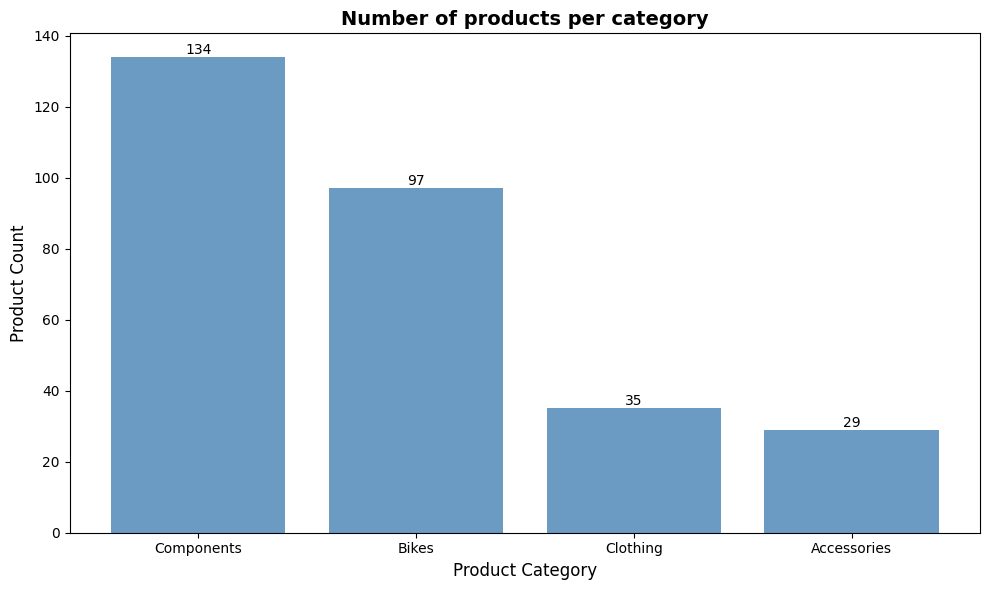

  CategoryName ProductCount
0   Components          134
1        Bikes           97
2     Clothing           35
3  Accessories           29


In [12]:
query_vis_1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID  = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis_1 = query_df(query_vis_1)

fig, ax = plt.subplots(figsize = (10,6))
bars = ax.bar(df_vis_1['CategoryName'], df_vis_1['ProductCount'], color = 'steelblue', alpha = 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{int(height)}",
        ha = 'center',
        va = 'bottom'
    )

ax.set_xlabel('Product Category', fontsize = 12)
ax.set_ylabel('Product Count', fontsize = 12)
ax.set_title('Number of products per category', fontsize = 14, fontweight = 'bold')
plt.tight_layout()
plt.show()
print(df_vis_1.assign(ProductCount=df_vis_1["ProductCount"].map(lambda x: f"{x:,.0f}"))[["CategoryName", "ProductCount"]])

### Insights - Products Per Catoegory
* Components is the largest category with 134 products.
* Accessories is the smallest category with 29 products.

This indicates that the company is highly focused on components and spare parts. And that accessories could be a area of development.

## Visualization 2: Sales Per Category
Which category generates the highest amount of sales?

Tables used:
* Production.ProductCategory
* Production.ProductSubCategory
* Production.Product
* Sales.SalesOrderDetail

Execution:
* JOIN Tables
* Sum sales per category
* Create Horizontal chart
* Analyze result

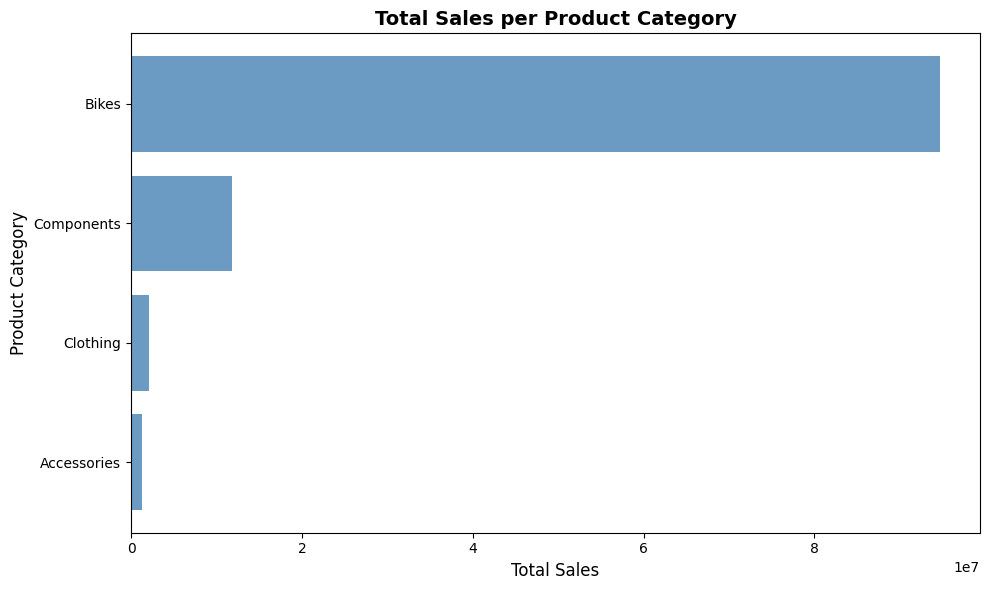

      Category  TotalSales
0        Bikes  94,651,173
1   Components  11,802,593
2     Clothing   2,120,543
3  Accessories   1,272,073


In [13]:
query_vis_2 = """
SELECT
    pc.Name AS Category,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON p.ProductID = sod.ProductID
JOIN Production.ProductSubcategory psc ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Production.ProductCategory pc ON pc.ProductCategoryID = psc.ProductCategoryID
GROUP BY pc.Name
ORDER BY TotalSales DESC
"""

df_vis_2 = query_df(query_vis_2)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.barh(df_vis_2['Category'], df_vis_2['TotalSales'], color='steelblue', alpha=0.8)

# for bar in bars:
#     width = bar.get_width()
#     ax.text(
#         width,
#         bar.get_y() + bar.get_height() / 2,
#         f"{width:,.0f}",
#         va='center',
#         ha='left'
#     )

ax.set_xlabel('Total Sales', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)
ax.set_title('Total Sales per Product Category', fontsize=14, fontweight='bold')

ax.invert_yaxis() 
plt.tight_layout()
plt.show()

print(df_vis_2.assign(TotalSales=df_vis_2["TotalSales"].map(lambda x: f"{x:,.0f}"))[["Category", "TotalSales"]])


### Insights - Sales Per Catoegory
* Bikes has the highest amount of sales with 94.651.173.
* Accessories has the lowest amount of sales with 1.272.073.

Sales are highly concentrated in the Bikes category, which generates significantly more revenue than all other categories.

## Visualization 3: Sales Trend Over Time
What does the sales trend look like over time?

Tables used:
* Sales.SalesOrderHeader

Execution:
* Sum sales per category
* Create Horizontal chart
* Analyze result

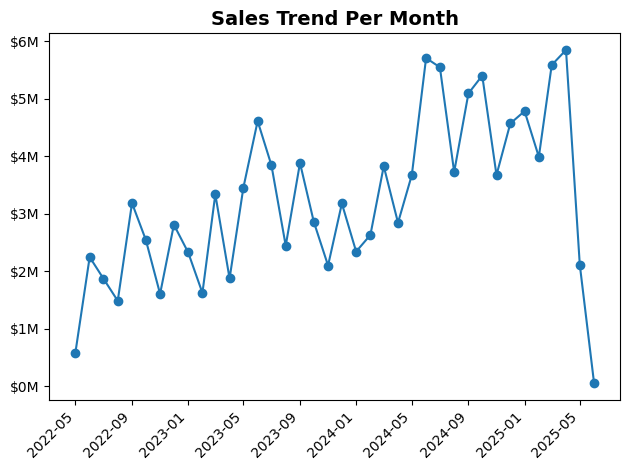

Highest month: 2025-04 (5.8M)
Lowest month: 2025-06 (0.1M)


In [14]:
query_vis_3 = """
SELECT
    YEAR(OrderDate) AS [Year],
    MONTH(OrderDate) AS [MonthNr],
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY
    YEAR(OrderDate), MONTH(OrderDate)
ORDER BY
    [Year], [MonthNr]

"""

df_vis_3 = query_df(query_vis_3)

df_vis_3['Month'] = pd.to_datetime(df_vis_3['Year'].astype(str) + '-' + df_vis_3['MonthNr'].astype(str) + '-01')

# plt.plot(df_vis_3['Month'], df_vis_3['TotalSales'])
plt.plot(df_vis_3['Month'], df_vis_3['TotalSales'], marker='o')

plt.title('Sales Trend Per Month', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: f'${x/1_000_000:.0f}M'))
plt.tight_layout()
plt.show()

max_row = df_vis_3.loc[df_vis_3['TotalSales'].idxmax()]
min_row = df_vis_3.loc[df_vis_3['TotalSales'].idxmin()]

print(f"Highest month: {max_row['Month'].strftime('%Y-%m')} ({max_row['TotalSales']/1_000_000:.1f}M)")
print(f"Lowest month: {min_row['Month'].strftime('%Y-%m')} ({min_row['TotalSales']/1_000_000:.1f}M)")


### Insights – Sales Trend Over Time
* Highest Monthly: 2025-04 (5847164.693)
* Lowest Mothly: 2025-06 (52478.1872)

Sales show variation over time, with noticeable peaks and troughs across months. With a observable trend upwards, that seem to have ended abruptly at peak month 2025-04.


## Visualization 4: Sales And Orders Per Year
What does the total sales and orders per year look like?

Tables used:
* Sales.SalesOrderHeader

Execution:
* Lorem ipsum
* Lorem ipsum
* Lorem ipsum chart
* Analyze result

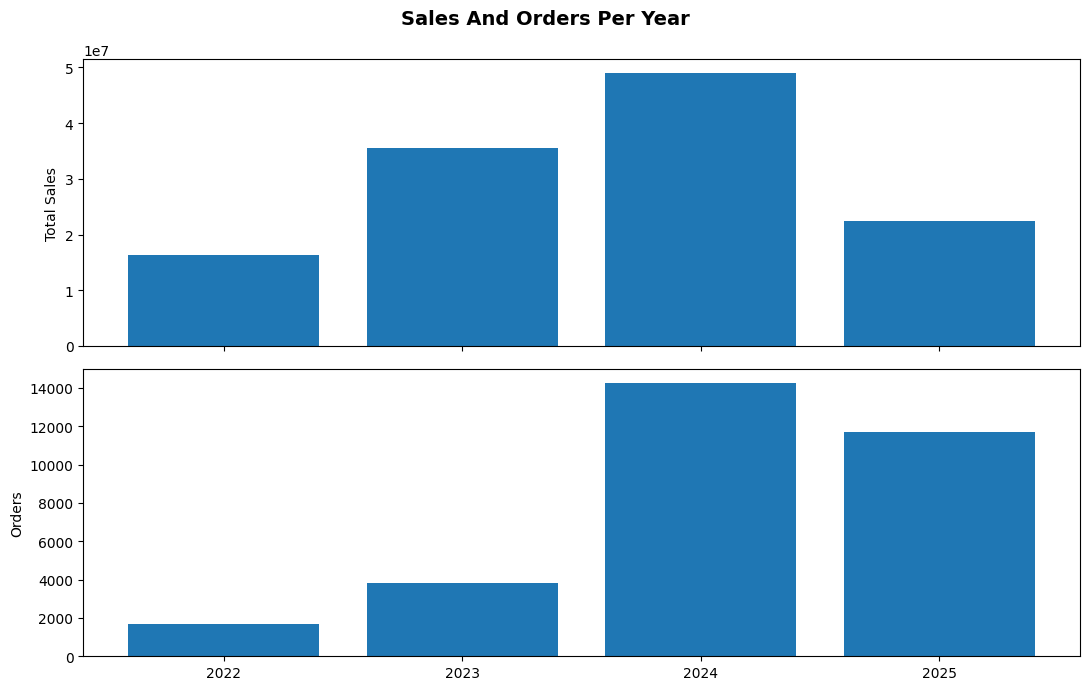

Highest Sales: 2024 (49020486.512)
Lowest Sales: 2022 (16316694.169)
Highest Orders: 2024 (14244)
Lowest Orders: 2022 (1692)


In [15]:
query_vis_4 = """
SELECT
    YEAR(OrderDate) AS [Year],
    SUM(TotalDue) AS TotalSales,
    COUNT(*) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY [Year]
"""

df_vis_4 = query_df(query_vis_4)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,7), sharex=True)
fig.suptitle("Sales And Orders Per Year", fontsize=14, fontweight='bold')
ax1.bar(df_vis_4["Year"], df_vis_4["TotalSales"])
ax1.set_ylabel("Total Sales")

ax2.bar(df_vis_4["Year"], df_vis_4["OrderCount"])
ax2.set_ylabel("Orders")
ax2.set_xticks(df_vis_4["Year"])
ax2.set_xticklabels(df_vis_4["Year"])
plt.tight_layout()
plt.show()

max_sales = df_vis_4.loc[df_vis_4['TotalSales'].idxmax()]
min_sales = df_vis_4.loc[df_vis_4["TotalSales"].idxmin()]
max_orders = df_vis_4.loc[df_vis_4['OrderCount'].idxmax()]
min_orders = df_vis_4.loc[df_vis_4['OrderCount'].idxmin()]

print(f"Highest Sales: {int(max_sales['Year'])} ({max_sales['TotalSales']:})")
print(f"Lowest Sales: {int(min_sales['Year'])} ({min_sales['TotalSales']:})")
print(f"Highest Orders: {int(max_orders['Year'])} ({int(max_orders['OrderCount'])})")
print(f"Lowest Orders: {int(min_orders['Year'])} ({int(min_orders['OrderCount'])})")

### Insights – Sales And Orders Per Year
* Highest Yearly Sales: 2024 (49020486.512)
* Lowest Yearly Sales: 2022 (16316694.169)
* Highest Yearly Orders: 2024 (14244)
* Lowest Yearly Orders: 2022 (1692)

Lorem ipsum

## Visualization 5: Top 10 Products
What Top 10 products generates most sales?

Tables used:
* Production.Product
* Sales.SalesOrderDetail

Execution:
* Lorem ipsum
* Lorem ipsum
* Lorem ipsum chart
* Analyze result

In [16]:
# code

### Insights – Top 10 Products
* Lorem Ipsum
* Lorem Ipsum
* Lorem Ipsum
* Lorem Ipsum

Lorem ipsum

## Visualization 6: Sales And Number Of Customers Per Region
Diffrences in Sales per Region. And how many unique customers per region?

Tables used:
* Sales.SalesTerritory
* Sales.SalesOrderHeader
* Sales.Customer

Execution:
* Lorem ipsum
* Lorem ipsum
* Lorem ipsum chart
* Analyze result

In [17]:
# Code

### Insights – Sales And Number Of Customers Per Region
* Lorem Ipsum
* Lorem Ipsum
* Lorem Ipsum
* Lorem Ipsum

Lorem ipsum

## Visualization 7: Average Order Value Per Region And Customer Type
Which regions has the highest/lowest average order value and diffrences between individual customers and business clients?

Tables used:
* Sales.SalesTerritory
* Sales.SalesOrderHeader
* Sales.Customer
* Sales.Store

Execution:
* Lorem ipsum
* Lorem ipsum
* Lorem ipsum chart
* Analyze result

In [18]:
# Code

### Insights – Average Order Value Per Region And Customer Type
* Lorem Ipsum
* Lorem Ipsum
* Lorem Ipsum
* Lorem Ipsum

Lorem ipsum